### 卡通圖片生成
檔案高達500MB
> https://drive.google.com/open?id=1yPgkbRGs1ihDoUJKEVhrZ9qb6-GHIBF3

In [1]:
import tensorflow as tf
import os 

os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
config = tf.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 0.2
session = tf.Session(config=config)

In [2]:
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import os

from keras.losses import binary_crossentropy
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, Dense, Input, BatchNormalization, Flatten, Lambda, Reshape, LeakyReLU, ReLU

In [8]:
from glob import glob
# 查看照片有幾張
len(glob('./cartoon/*.png'))

10000

範例code
> https://drive.google.com/file/d/104C4oZn07HEddGQI9E0-KAo24oSvGJYt/view

In [7]:
class VAE:
    def __init__(self, latent_dim=100, img_path='./cartoon'):
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 3
        self.img_size = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = latent_dim
        self.img_path_list = glob(img_path + '/*.png')
        self.img_data = self.load_data(self.img_size, self.img_path_list)
    
    def load_data(self, img_res, path_list):
        def imread(path, img_res):           
            return np.array(Image.open(path).convert('RGB').resize(img_res, Image.ANTIALIAS)) / 255
        
        img_set = np.zeros((len(path_list), ) + img_res)
        for idx, rand_img_path in enumerate(path_list):
            img_set[idx] = imread(rand_img_path, img_res[:2])[:,:,:3]
        return img_set
    
    def build_encoder(self):
        def sampling(args):
            z_mu, z_logvar = args
            batch = K.shape(z_mu)[0]
            dim = K.int_shape(z_mu)[1]
            epsilon = K.random_normal(shape=(batch, dim))
            return z_mu + K.exp(0.5 * z_logvar) * epsilon
        
        inputs = Input(shape=self.img_size, name='encoder_input')        
        h = Conv2D(16, kernel_size=4, strides=2, padding='same', name='conv1')(inputs)
        h = LeakyReLU(alpha=0.2)(h)
        
        h = Conv2D(32, kernel_size=4, strides=2, padding='same', name='conv2')(h)
        h = BatchNormalization()(h)
        h = LeakyReLU(alpha=0.2)(h)
        
        h = Conv2D(64, kernel_size=4, strides=2, padding='same', name='conv3')(h)
        h = BatchNormalization()(h)
        h = LeakyReLU(alpha=0.2)(h)
        
        h = Conv2D(128, kernel_size=4, strides=2, padding='same', name='conv4')(h)
        h = BatchNormalization()(h)
        h = ReLU()(h)
        
        h = Flatten()(h)
                
        z_mu = Dense(latent_dim, name='z_mu')(h)
        z_logvar = Dense(latent_dim, name='z_logvar')(h)
        # 封裝成layer
        z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mu, z_logvar])
        
        return Model(inputs, [z, z_mu, z_logvar], name='encoder')

    def build_decoder(self):
        latent_inputs = Input(shape=(self.latent_dim,), name='z_sampling')
        h = Reshape((1, 1, self.latent_dim))(latent_inputs)
        h = Conv2DTranspose(128, kernel_size=4, strides=1, padding='valid', name='convT1')(h)
        h = BatchNormalization()(h)
        h = LeakyReLU(alpha=0.2)(h)
        
        h = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', name='convT2')(h)
        h = BatchNormalization()(h)
        h = LeakyReLU(alpha=0.2)(h)

        h = Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', name='convT3')(h)
        h = BatchNormalization()(h)
        h = LeakyReLU(alpha=0.2)(h)
        
        h = Conv2DTranspose(16, kernel_size=4, strides=2, padding='same', name='convT4')(h)
        h = BatchNormalization()(h)
        h = LeakyReLU(alpha=0.2)(h)
        
        outputs = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='sigmoid', name='convT5')(h)

        return Model(latent_inputs, outputs, name='decoder')
    
    def connect(self):
        img_input = Input(shape=self.img_size)
        self.encoder = self.build_encoder()
        #self.encoder.summary()
        self.decoder = self.build_decoder()
        #self.decoder.summary()
        output = self.decoder(self.encoder(img_input)[0])
        
        self.combined = Model(img_input, output, name='vae')
        
        _, z_mu, z_logvar = self.encoder.get_output_at(-1)
        reconstruction_loss = binary_crossentropy(K.flatten(img_input), K.flatten(output))
        reconstruction_loss *= self.img_size[0] * self.img_size[1] * self.img_size[2]
        
        kl_loss = 1 + z_logvar - K.square(z_mu) - K.exp(z_logvar)
        kl_loss = K.sum(kl_loss, axis=-1) * -.5
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        self.combined.add_loss(vae_loss)
        self.combined.compile(optimizer='adam')
        
    def sample_image(self, iteration):
        r, c = 4, 3
        idx = np.random.choice(len(self.img_data), r*c, replace=False)
        y = self.combined.predict(self.img_data[idx])

        fig, axs = plt.subplots(r, c, figsize=(10,10))
        cnt = 0
        for j in range(r):
            for i in range(c):
                show = np.zeros((self.img_size[0], self.img_size[1]*2, self.img_size[2]))
                show[:,:self.img_size[1]] = self.img_data[idx[cnt]]
                show[:,self.img_size[1]:] = y[cnt]
                axs[j, i].imshow(show)
                axs[j, i].axis('off')
                cnt = cnt+1
        fig.savefig("images/reconst/%d.png" % iteration)
        plt.close()
    
    def generate_image(self, iteration):
        r, c = 4, 4
        z = np.random.standard_normal((r*c, self.latent_dim))
        gen_img = self.decoder.predict(z)
        
        fig, axs = plt.subplots(r, c, figsize=(10,10))
        cnt = 0
        for j in range(r):
            for i in range(c):                
                axs[j, i].imshow(gen_img[cnt])
                axs[j, i].axis('off')
                cnt = cnt+1
        fig.savefig("images/generate/%d.png" % iteration)
        plt.close()
        
    def generate_morphing_image(self):
        r, c = 7, 7
        z = np.zeros((r*c, self.latent_dim))
        z[0] = np.random.standard_normal((1, self.latent_dim))
        tmp = np.random.standard_normal((1, self.latent_dim)) - z[0]
        for i in range(1, len(z)):
            z[i] = z[i-1] + tmp / (r*c)      
        
        gen_img = self.decoder.predict(z)
        fig, axs = plt.subplots(r, c, figsize=(10,10))
        cnt = 0
        for j in range(r):
            for i in range(c):                
                axs[j, i].imshow(gen_img[cnt])
                axs[j, i].axis('off')
                cnt = cnt+1
        fig.savefig("images/morphing.png")
        plt.close()
    
    def show(self):
        plt.plot(list(range(len(self.history))), self.history)
        plt.ylabel('Loss')
        plt.xlabel('epochs')
        plt.title('Learning curve')
        plt.savefig('images/learning_curve.png')

    def train(self, epochs, batch_size):
        self.history = [] 
        for i in range(epochs):
            history = self.combined.fit(self.img_data, epochs=1, batch_size=batch_size, verbose=0)
            self.history += history.history['loss']            
            if i % 10 == 0:
                print("[Epoch %d/%d] [VAE loss: %f]" % (i, epochs, self.history[-1]))
                self.sample_image(i)
                self.generate_image(i)

In [8]:
batch_size = 100
latent_dim = 50
epochs = 200
if not os.path.exists('images/reconst'):
    os.makedirs('images/reconst')
if not os.path.exists('images/generate'):
    os.makedirs('images/generate')

[Epoch 0/200] [VAE loss: 4388.832800]
[Epoch 10/200] [VAE loss: 1808.127864]
[Epoch 20/200] [VAE loss: 1773.502456]
[Epoch 30/200] [VAE loss: 1760.468622]
[Epoch 40/200] [VAE loss: 1751.882668]
[Epoch 50/200] [VAE loss: 1746.817916]
[Epoch 60/200] [VAE loss: 1741.669037]
[Epoch 70/200] [VAE loss: 1740.344943]
[Epoch 80/200] [VAE loss: 1736.072860]
[Epoch 90/200] [VAE loss: 1734.449540]
[Epoch 100/200] [VAE loss: 1732.491997]
[Epoch 110/200] [VAE loss: 1731.069037]
[Epoch 120/200] [VAE loss: 1728.851628]
[Epoch 130/200] [VAE loss: 1727.570599]
[Epoch 140/200] [VAE loss: 1727.235914]
[Epoch 150/200] [VAE loss: 1726.014387]
[Epoch 160/200] [VAE loss: 1725.169625]
[Epoch 170/200] [VAE loss: 1724.059745]
[Epoch 180/200] [VAE loss: 1723.085514]
[Epoch 190/200] [VAE loss: 1722.711204]


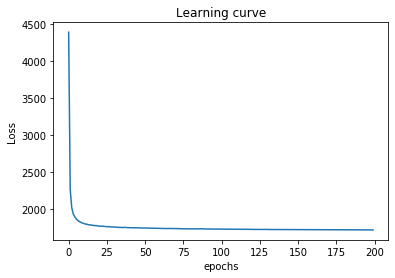

In [9]:
%% time

vae = VAE(latent_dim=latent_dim)
vae.connect()
vae.train(epochs, batch_size)
vae.show()

In [10]:
%%time
vae.generate_morphing_image()